In [2]:
import os
from convokit import Corpus, download

filename = "~/.convokit/downloads/friends-corpus"
# corpus = Corpus(download('friends-corpus'))
corpus = Corpus(filename=os.path.expanduser(filename))

utterance = corpus.get_utterance('s07_e14_c01_u018')
print(utterance.speaker.id)
print(utterance.text)

Rachel Green
Well, can I keep the presents and still be 29?


In [3]:
import re
re_pattern = "[^0-9a-zA-Z,.?!' ]"

def get_example(utterance):
    speaker = utterance.speaker.id
    if speaker == "TRANSCRIPT_NOTE":
        # Only interested in conversations
        return ''
    # Limit vocabulary to 0-9, a-z, A-Z, and some punctuations (,.?!)
    return re.sub(re_pattern, '', utterance.text)

examples = list(map(get_example, corpus.iter_utterances()))
examples[0]

"There's nothing to tell! He's just some guy I work with!"

## Build the vocabulary

In [4]:
all_characters = set([])
for example in examples:
    all_characters.update(list(example))
all_characters = list(all_characters)
print("Dictionary size:", len(all_characters))

stoi = {s:i + 1 for i, s in enumerate(sorted(all_characters))}
itos = {i:s for s, i in stoi.items()}
print(stoi)

Dictionary size: 68
{' ': 1, '!': 2, "'": 3, ',': 4, '.': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '?': 16, 'A': 17, 'B': 18, 'C': 19, 'D': 20, 'E': 21, 'F': 22, 'G': 23, 'H': 24, 'I': 25, 'J': 26, 'K': 27, 'L': 28, 'M': 29, 'N': 30, 'O': 31, 'P': 32, 'Q': 33, 'R': 34, 'S': 35, 'T': 36, 'U': 37, 'V': 38, 'W': 39, 'X': 40, 'Y': 41, 'Z': 42, 'a': 43, 'b': 44, 'c': 45, 'd': 46, 'e': 47, 'f': 48, 'g': 49, 'h': 50, 'i': 51, 'j': 52, 'k': 53, 'l': 54, 'm': 55, 'n': 56, 'o': 57, 'p': 58, 'q': 59, 'r': 60, 's': 61, 't': 62, 'u': 63, 'v': 64, 'w': 65, 'x': 66, 'y': 67, 'z': 68}


## Build the dataset

In [5]:
import torch
import torch.nn.functional as F

SPECIAL_SE = '@'
stoi[SPECIAL_SE] = 0
itos[0] = SPECIAL_SE

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '@':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # 'abcd' -> 'bcde'

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(examples)

n1 = int(0.8 * len(examples))
n2 = int(0.9 * len(examples))
Xtr, Ytr = build_dataset(examples[:n1])
Xval, Yval = build_dataset(examples[n1:n2])
Xtest, Ytest = build_dataset(examples[n2:])

torch.Size([2605041, 3]) torch.Size([2605041])
torch.Size([317795, 3]) torch.Size([317795])
torch.Size([327782, 3]) torch.Size([327782])


## "Torchify" our implementations

Make our implementation follows the API design in PyTorch, e.g.,
```python
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,20,5),
    torch.nn.ReLU(),
    torch.nn.Conv2d(20,64,5),
    torch.nn.ReLU()
)

```

In [12]:
# Linear model, i.e. x @ W + b
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# Map the context characters to an embedding vector
class Embedding:
    def __init__(self, vocab_size, embedding_dim):
        self.embedding_dim = embedding_dim
        self.weight = torch.randn((vocab_size, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]


# Concatenate the embedding of all context characters
class Concat:
    def __init__(self, block_size):
        self.block_size = block_size

    def __call__(self, x):
        B, T, C = x.shape
        assert(T == self.block_size)
        self.out = x.view(-1, T * C)
        return self.out

    def parameters(self):
        return []

## Batch normalization

The main benefit of batch normalization (BN) is to reduce internal covariate shift.

**Internal Covariate Shift:** It means the distributions of each layer's inputs change during training as we adjust the weights and biases from backpropagation. This distribution shift is problematic because it forces downstream layers to continuously adapt, slowing down training and complicating convergence to an optimal solution.

**How Batch Normalization Helps:**
BN normalizes the inputs to each layer. The input to layers has a consistent mean and variance so that each layer doesn't have to keep readjusting to new input distributions, allowing for more stable and faster training.

In [13]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # moving average
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize input
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

## Build a deeper network

In [16]:
n_embed = 10
n_hidden = 100
vocab_size = len(stoi)

model = [
    Embedding(vocab_size, n_embed), Concat(block_size),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

parameters = [p for layer in model for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

41459


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(len(Xtr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    for layer in model:
        Xb = layer(Xb)
    loss = F.cross_entropy(Xb, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    lossi.append(loss.item())
    if i % 1000 == 0:
        print(i, loss.item())

    # Remove after making sure the code works
    # if i >= 5000:
    #     break

200000 1.8845503330230713
201000 1.9302845001220703
202000 1.7850219011306763
203000 1.6162630319595337
204000 2.072871685028076
205000 2.4437003135681152
206000 1.27915620803833
207000 1.4510880708694458
208000 1.9287217855453491
209000 1.5703084468841553
210000 1.5282533168792725
211000 1.454378604888916
212000 1.917089581489563
213000 1.93467116355896
214000 1.58807373046875
215000 1.613409161567688
216000 1.7341368198394775
217000 1.2640281915664673
218000 1.782745599746704
219000 1.8351987600326538
220000 1.3830233812332153
221000 1.4925309419631958
222000 1.5054957866668701
223000 1.711880087852478
224000 1.4011919498443604
225000 1.6500146389007568
226000 1.5068219900131226
227000 1.2554322481155396
228000 1.7855569124221802
229000 1.334743857383728
230000 2.2713375091552734
231000 1.290276050567627
232000 1.5752860307693481
233000 1.8081388473510742
234000 1.8058013916015625
235000 2.0154690742492676
236000 1.6758646965026855
237000 1.4697726964950562
238000 1.6846779584884644


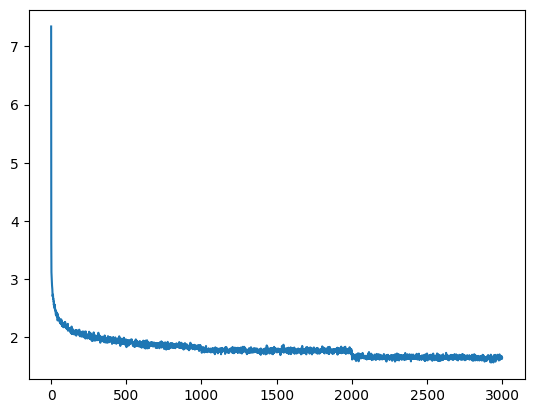

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(
    # lossi
    torch.tensor(lossi).view(-1, 100).mean(dim=1).flatten().tolist()
)

## Evaluation

In [25]:
for layer in model:
    layer.training = False

In [26]:
def evaluation(X, Y):
    with torch.no_grad():
        for layer in model:
            X = layer(X)
        loss = F.cross_entropy(X, Y)
    return loss.item()

evaluation(Xtr, Ytr), evaluation(Xval, Yval)

(1.647695541381836, 1.643833875656128)

In [27]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        X = torch.tensor([context]) # (1, block_size)
        with torch.no_grad():
            for layer in model:
                X = layer(X)
            prob = F.softmax(X, dim=1)
            ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join([itos[i] for i in out]))

Well, weur for them I do procpeld be tj5.
Ther!
No? Phey my God to got it's fant elk, I'm you.
Yef!
I reat you know, y'know what?

It's on, sharrin at Martor!
I ther.
Hi!
So, what time for my Give wortry my God, itipe'll me!
